### Limpieza de datos
Limpieza del archivo con los datos para el modelo de consumo individual consumo_salamanca.csv 

### Cargar y limpiar el dataset
En esta celda se cargan los datos, se convierten las columnas relevantes a tipos adecuados y se eliminan valores no válidos.

In [1]:
import pandas as pd

# Cargar el dataset
file_path = '../../../raw/datos_consumo/hogar_salamanca/consumo_salamanca.csv'
df = pd.read_csv(file_path)

df.columns


Index(['datetime', 'Fecha', 'Hora', 'Consumo_kWh', 'Metodo_obtencion', 'id',
       'name', 'geoid', 'geoname', 'value', 'date', 'fecha', 'indicativo',
       'nombre', 'provincia', 'altitud', 'tmed', 'prec', 'tmin', 'horatmin',
       'tmax', 'horatmax', 'dir', 'velmedia', 'racha', 'horaracha', 'sol',
       'presMax', 'horaPresMax', 'presMin', 'horaPresMin', 'hrMedia', 'hrMax',
       'horaHrMax', 'hrMin', 'horaHrMin'],
      dtype='object')

#### Análisis y selección de variables del dataset

Columnas del dataset

El dataset contiene las siguientes columnas:

- **datetime, Fecha, Hora**: Información temporal.
- **Consumo_kWh**: Consumo energético en kWh.
- **Metodo_obtencion**: Método de obtención del dato.
- **id, name, geoid, geoname**: Identificadores y nombres geográficos.
- **value**: No está claro su significado exacto.
- **date, fecha**: Posibles duplicados de `datetime`.
- **indicativo, nombre, provincia, altitud**: Información de ubicación.
- **tmed, prec, tmin, horatmin, tmax, horatmax**: Variables meteorológicas (temperatura, precipitaciones).
- **dir, velmedia, racha, horaracha**: Datos de viento.
- **sol**: Horas de sol.
- **presMax, horaPresMax, presMin, horaPresMin**: Presión atmosférica.
- **hrMedia, hrMax, horaHrMax, hrMin, horaHrMin**: Humedad relativa.

#### Variables útiles para Prophet

Para construir un modelo de predicción con Prophet, se seleccionarán las siguientes variables:

1. **`datetime`**: Variable de tiempo requerida por Prophet.
2. **`Consumo_kWh`**: Variable objetivo (lo que queremos predecir).
3. **Factores meteorológicos** que pueden influir en el consumo:
   - **Temperatura**: `tmed`, `tmin`, `tmax`
   - **Precipitaciones**: `prec`
   - **Horas de sol**: `sol`
   - **Humedad**: `hrMedia`

In [2]:
# Definir las columnas de interés
columns_of_interest = ['datetime', 'Consumo_kWh', 'tmed', 'tmin', 'tmax', 'prec', 'sol', 'hrMedia']

# Crear un nuevo DataFrame con solo estas columnas
df = df[columns_of_interest].copy()

# Convertir datetime a formato datetime
df['datetime'] = pd.to_datetime(df['datetime'])

# Reemplazar comas por puntos y convertir a float en Consumo_kWh
df['Consumo_kWh'] = df['Consumo_kWh'].astype(str).str.replace(',', '.').astype(float)

df


,datetime,Consumo_kWh,tmed,tmin,tmax,prec,sol,hrMedia
0,2020-07-31 22:00:00+00:00,0.000,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-07-31 23:00:00+00:00,0.000,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-08-01 00:00:00+00:00,0.000,"23,2","12,8","33,6","0,0","13,9",41.0
3,2020-08-01 01:00:00+00:00,0.000,"23,2","12,8","33,6","0,0","13,9",41.0
4,2020-08-01 02:00:00+00:00,0.000,"23,2","12,8","33,6","0,0","13,9",41.0
...,...,...,...,...,...,...,...,...
40027,2025-02-23 18:00:00+00:00,0.296,NaN,NaN,NaN,NaN,NaN,NaN
40028,2025-02-23 19:00:00+00:00,0.111,NaN,NaN,NaN,NaN,NaN,NaN
40029,2025-02-23 20:00:00+00:00,0.099,NaN,NaN,NaN,NaN,NaN,NaN
40030,2025-02-23 21:00:00+00:00,0.160,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# Lista de columnas meteorológicas a convertir
columns_to_fix = ['tmed', 'tmin', 'tmax', 'prec', 'sol', 'hrMedia']

# Reemplazar valores 'nan' string por valores NaN reales antes de la conversión
df[columns_to_fix] = df[columns_to_fix].replace('nan', pd.NA)

# Limpiar las columnas: eliminar espacios y caracteres no numéricos antes de convertir
for col in columns_to_fix:
    df[col] = df[col].astype(str).str.strip()  # Eliminar espacios en blanco
    df[col] = df[col].replace({'nan': None, 'NA': None, '': None})  # Reemplazar valores problemáticos


In [4]:
# Contar valores nulos en las columnas clave
df[columns_to_fix + ['Consumo_kWh']].isnull().sum()

tmed            102
tmin            102
tmax            102
prec             54
sol             390
hrMedia        1252
Consumo_kWh    4309
dtype: int64

In [5]:
# Ver los valores únicos después de la limpieza
unique_values_after_cleaning = {col: df[col].astype(str).unique()[:10] for col in columns_to_fix}

# Mostrar los valores únicos después de la limpieza
unique_values_after_cleaning


{'tmed': array(['None', '23,2', '21,8', '22,0', '22,4', '26,6', '26,4', '26,5',
        '26,0', '24,5'], dtype=object),
 'tmin': array(['None', '12,8', '13,6', '14,0', '13,4', '11,8', '14,1', '15,4',
        '15,2', '14,5'], dtype=object),
 'tmax': array(['None', '33,6', '30,1', '29,9', '31,3', '34,6', '39,1', '37,4',
        '37,8', '36,8'], dtype=object),
 'prec': array(['None', '0,0', '0,1', '3,3', 'Ip', '4,3', '5,0', '2,6', '2,3',
        '8,4'], dtype=object),
 'sol': array(['None', '13,9', '12,5', '13,6', '13,1', '10,9', '13,3', '12,8',
        '4,8', '6,0'], dtype=object),
 'hrMedia': array(['None', '41.0', '49.0', '42.0', '40.0', '33.0', '39.0', '37.0',
        '66.0', '63.0'], dtype=object)}

In [6]:
# Reemplazar comas por puntos en todas las columnas meteorológicas
for col in columns_to_fix:
    df[col] = df[col].astype(str).str.replace(',', '.')

# Convertir las columnas meteorológicas a tipo numérico
for col in columns_to_fix:
    df[col] = pd.to_numeric(df[col], errors='coerce')
    
# Contar valores nulos en las columnas meteorológicas después de la conversión
missing_values_after_conversion = df[columns_to_fix].isnull().sum()

# Mostrar los resultados
missing_values_after_conversion


tmed        102
tmin        102
tmax        102
prec       2382
sol         390
hrMedia    1252
dtype: int64

In [7]:
# Eliminar filas con valores nulos en las variables meteorológicas
df_cleaned = df.dropna(subset=columns_to_fix)

# Mostrar el tamaño final del dataset después de la limpieza
df_cleaned.shape

(36332, 8)

In [8]:
df_cleaned

,datetime,Consumo_kWh,tmed,tmin,tmax,prec,sol,hrMedia
2,2020-08-01 00:00:00+00:00,0.000,23.2,12.8,33.6,0.0,13.9,41.0
3,2020-08-01 01:00:00+00:00,0.000,23.2,12.8,33.6,0.0,13.9,41.0
4,2020-08-01 02:00:00+00:00,0.000,23.2,12.8,33.6,0.0,13.9,41.0
5,2020-08-01 03:00:00+00:00,0.000,23.2,12.8,33.6,0.0,13.9,41.0
6,2020-08-01 04:00:00+00:00,0.000,23.2,12.8,33.6,0.0,13.9,41.0
...,...,...,...,...,...,...,...,...
39980,2025-02-21 19:00:00+00:00,0.114,9.2,3.8,14.7,8.3,0.2,81.0
39981,2025-02-21 20:00:00+00:00,0.080,9.2,3.8,14.7,8.3,0.2,81.0
39982,2025-02-21 21:00:00+00:00,0.153,9.2,3.8,14.7,8.3,0.2,81.0
39983,2025-02-21 22:00:00+00:00,0.101,9.2,3.8,14.7,8.3,0.2,81.0


In [9]:
from datetime import datetime

# Lista de fechas festivas en Salamanca de 2020 a 2025
festivos_salamanca = [
    "2020-01-01", "2020-01-06", "2020-04-09", "2020-04-10", "2020-04-23", "2020-05-01",
    "2020-08-15", "2020-09-08", "2020-10-12", "2020-12-08", "2020-12-25",
    "2021-01-01", "2021-01-06", "2021-04-01", "2021-04-02", "2021-04-23", "2021-05-01",
    "2021-09-08", "2021-10-12", "2021-11-01", "2021-12-06", "2021-12-08", "2021-12-25",
    "2022-01-01", "2022-01-06", "2022-04-14", "2022-04-15", "2022-04-23", "2022-06-13",
    "2022-08-15", "2022-09-08", "2022-10-12", "2022-11-01", "2022-12-06", "2022-12-08",
    "2023-01-02", "2023-01-06", "2023-04-06", "2023-04-07", "2023-05-01", "2023-06-12",
    "2023-08-15", "2023-09-08", "2023-10-12", "2023-11-01", "2023-12-06", "2023-12-08", "2023-12-25",
    "2024-01-01", "2024-01-06", "2024-03-28", "2024-03-29", "2024-04-23", "2024-05-01", "2024-06-12",
    "2024-08-15", "2024-09-09", "2024-10-12", "2024-11-01", "2024-12-06", "2024-12-09", "2024-12-25",
    "2025-01-01", "2025-01-06", "2025-04-17", "2025-04-18", "2025-04-23", "2025-05-01", "2025-06-12",
    "2025-08-15", "2025-09-08", "2025-10-13", "2025-11-01", "2025-12-06", "2025-12-08", "2025-12-25"
]

# Convertir a formato datetime
festivos_salamanca = [datetime.strptime(date, "%Y-%m-%d").date() for date in festivos_salamanca]

# Crear la columna 'es_festivo' (1 si es festivo, 0 si no)
df_cleaned['es_festivo'] = df_cleaned['datetime'].dt.date.isin(festivos_salamanca).astype(int)

# Verificar la columna agregada
df_cleaned

/tmp/ipykernel_44617/198812748.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['es_festivo'] = df_cleaned['datetime'].dt.date.isin(festivos_salamanca).astype(int)


,datetime,Consumo_kWh,tmed,tmin,tmax,prec,sol,hrMedia,es_festivo
2,2020-08-01 00:00:00+00:00,0.000,23.2,12.8,33.6,0.0,13.9,41.0,0
3,2020-08-01 01:00:00+00:00,0.000,23.2,12.8,33.6,0.0,13.9,41.0,0
4,2020-08-01 02:00:00+00:00,0.000,23.2,12.8,33.6,0.0,13.9,41.0,0
5,2020-08-01 03:00:00+00:00,0.000,23.2,12.8,33.6,0.0,13.9,41.0,0
6,2020-08-01 04:00:00+00:00,0.000,23.2,12.8,33.6,0.0,13.9,41.0,0
...,...,...,...,...,...,...,...,...,...
39980,2025-02-21 19:00:00+00:00,0.114,9.2,3.8,14.7,8.3,0.2,81.0,0
39981,2025-02-21 20:00:00+00:00,0.080,9.2,3.8,14.7,8.3,0.2,81.0,0
39982,2025-02-21 21:00:00+00:00,0.153,9.2,3.8,14.7,8.3,0.2,81.0,0
39983,2025-02-21 22:00:00+00:00,0.101,9.2,3.8,14.7,8.3,0.2,81.0,0


In [10]:
# Definir la ruta donde se guardará el dataset procesado
output_file_path = "../../../processed/datos_consumo/hogar_salamanca/consumo_salamanca_cleaned.csv"

# Guardar el DataFrame con la columna `es_festivo`
df_cleaned.to_csv(output_file_path, index=False)


/tmp/ipykernel_44617/1110146320.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['datetime'] = pd.to_datetime(df_cleaned['datetime'])
/tmp/ipykernel_44617/1110146320.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['year'] = df_cleaned['datetime'].dt.year
/tmp/ipykernel_44617/1110146320.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

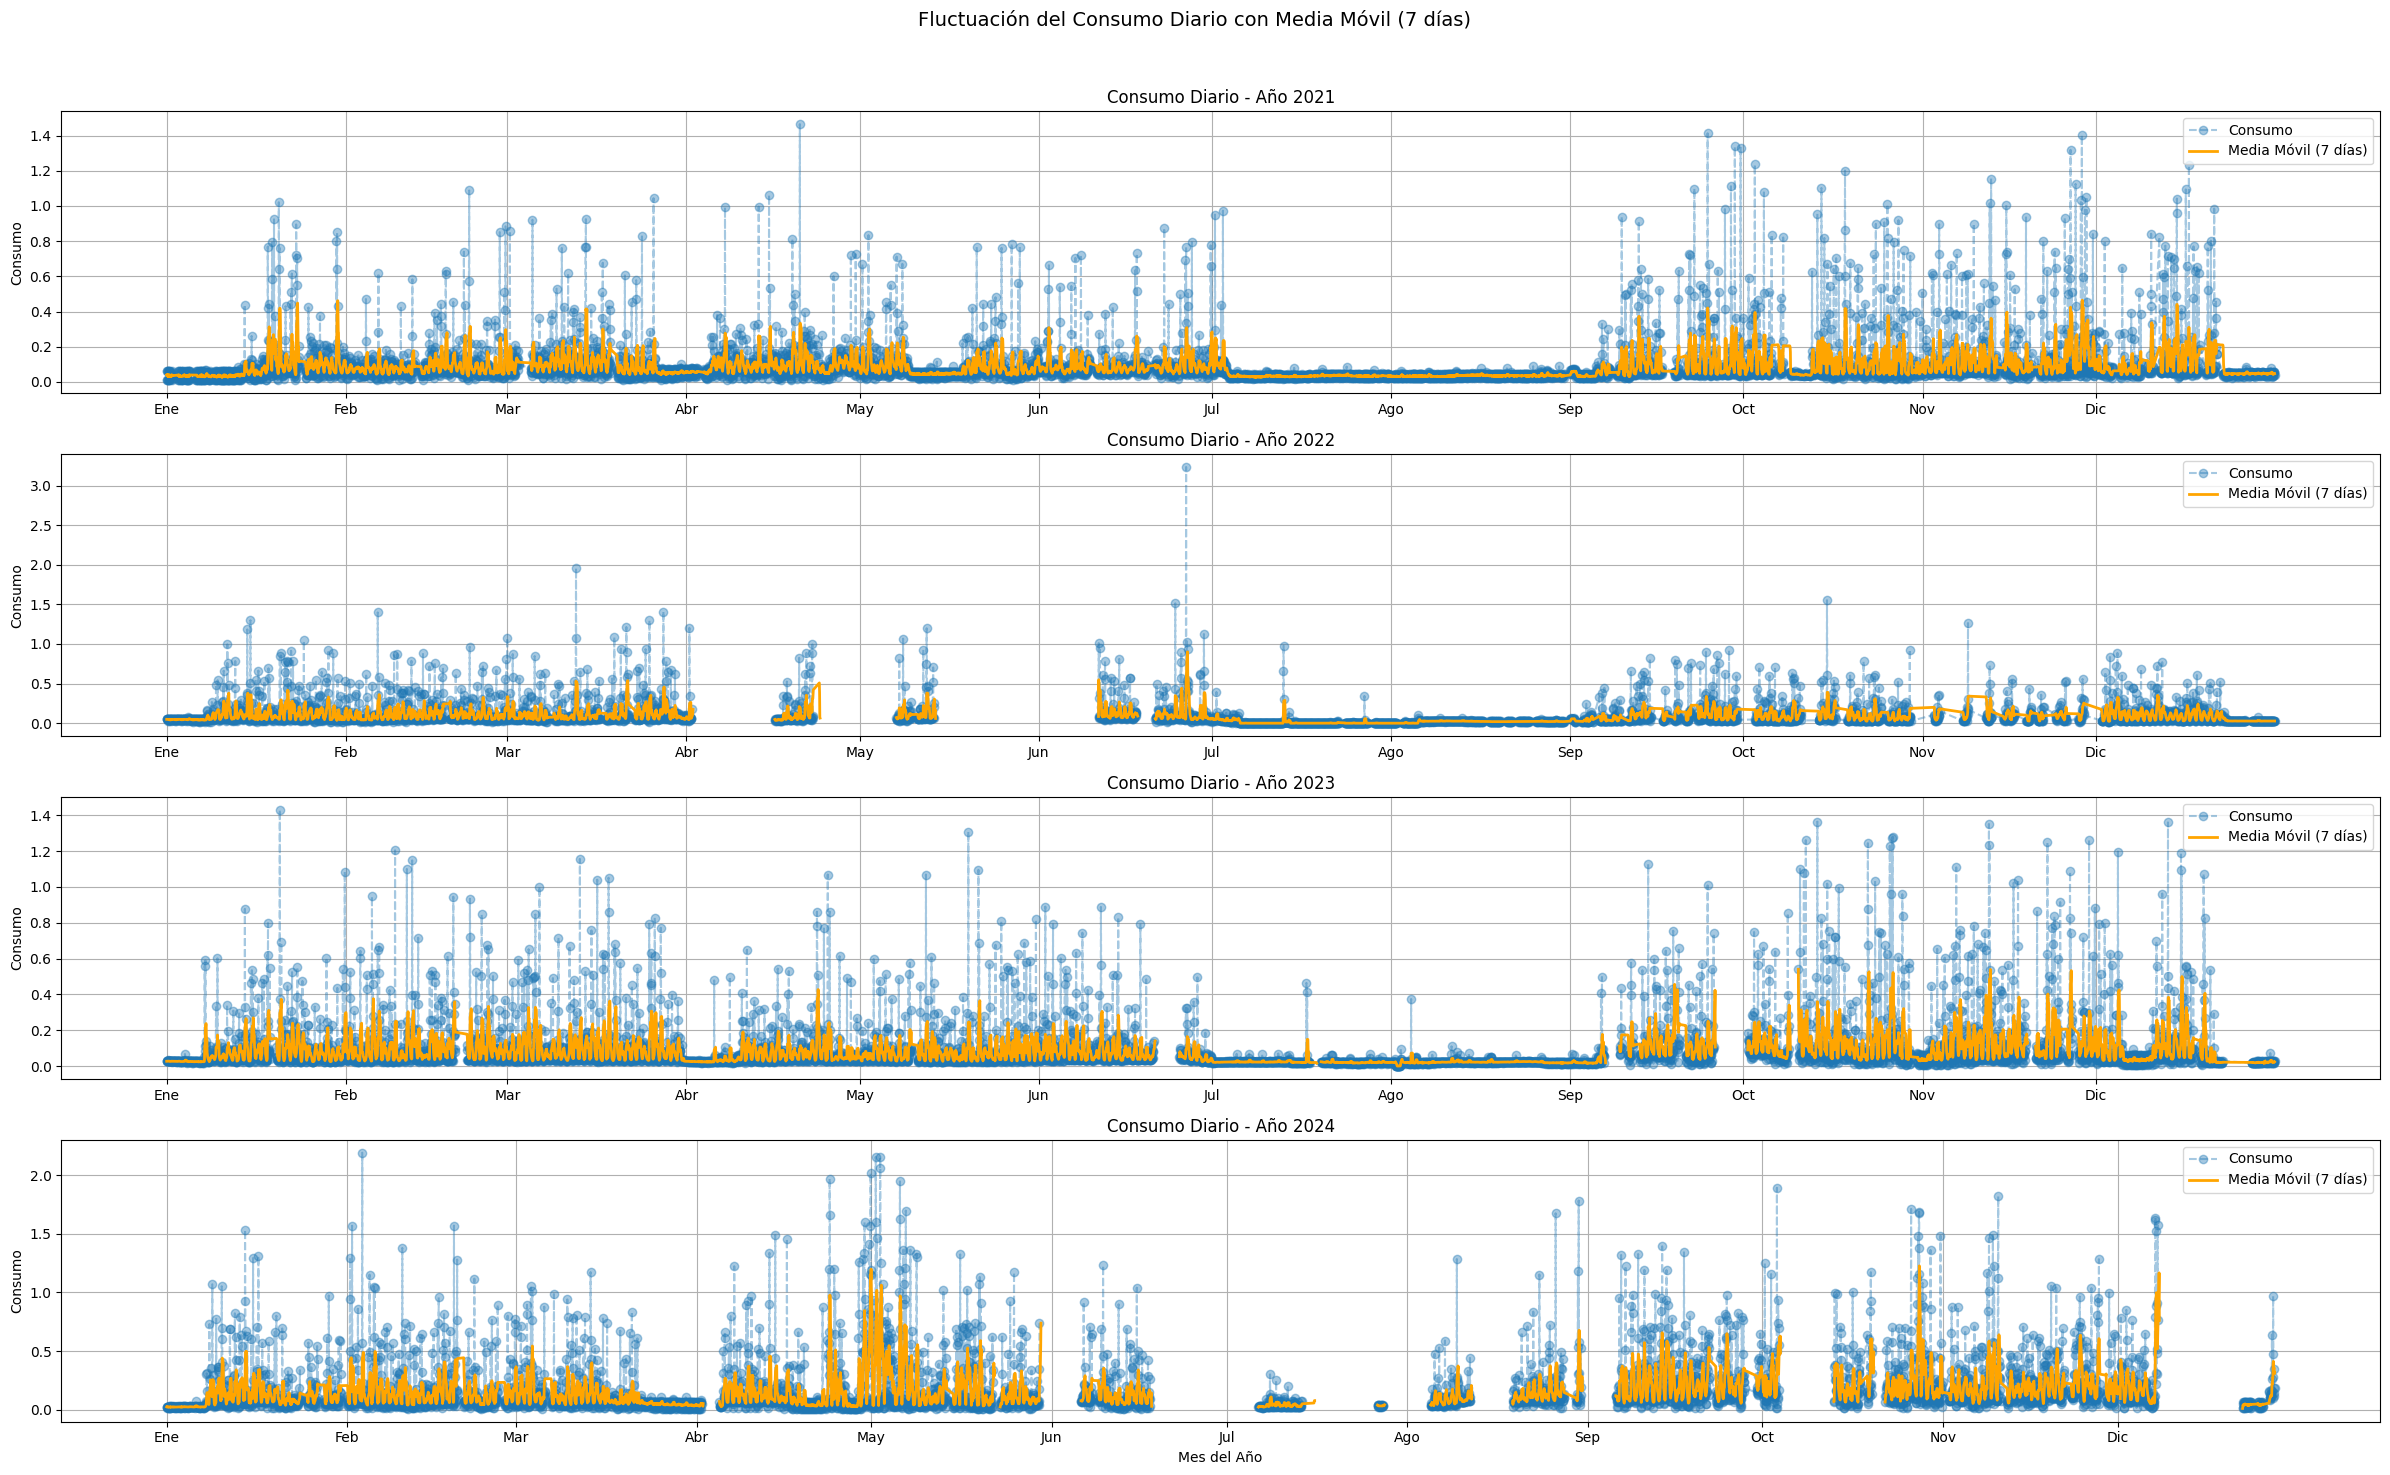

In [11]:
import matplotlib.pyplot as plt
import pandas as pd

# Asegurar que la columna de fecha está en formato datetime
df_cleaned['datetime'] = pd.to_datetime(df_cleaned['datetime'])

# Extraer año y mes para formatear el eje X
df_cleaned['year'] = df_cleaned['datetime'].dt.year
df_cleaned['month'] = df_cleaned['datetime'].dt.month

# Calcular la media móvil de 7 días
df_cleaned['moving_avg'] = df_cleaned['Consumo_kWh'].rolling(window=7, min_periods=1).mean()

# Definir el rango de años a graficar
years = [2021, 2022, 2023, 2024]

# Crear la figura con subgráficos en cascada
fig, axes = plt.subplots(len(years), 1, figsize=(24, 15), sharex=False)

# Graficar cada año en un subplot separado
for i, year in enumerate(years):
    ax = axes[i]
    data = df_cleaned[df_cleaned['year'] == year]
    
    ax.plot(data['datetime'], data['Consumo_kWh'], label="Consumo", marker='o', linestyle="dashed", alpha=0.4)
    ax.plot(data['datetime'], data['moving_avg'], label="Media Móvil (7 días)", linewidth=2, color="orange")
    
    ax.set_title(f"Consumo Diario - Año {year}")
    ax.set_ylabel("Consumo")
    ax.legend()
    ax.grid()

    # Formatear el eje X para que muestre solo los meses de ese año
    ax.set_xticks(pd.date_range(start=f"{year}-01-01", periods=12, freq="MS"))  # MS = Start of Month
    ax.set_xticklabels(["Ene", "Feb", "Mar", "Abr", "May", "Jun", "Jul", "Ago", "Sep", "Oct", "Nov", "Dic"])

plt.xlabel("Mes del Año")
plt.suptitle("Fluctuación del Consumo Diario con Media Móvil (7 días)", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
